

---



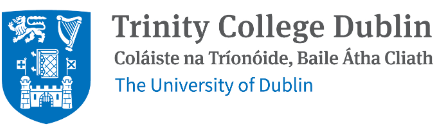



---



 ## ✈ Volatility Study Full Code ✈



---



### **Step 1:** Installing Dependencies `*Run this cell First*`

In [ ]:
%%capture
import os
import warnings
warnings.filterwarnings('ignore')
output_dir = '/content/Data_Study/Raw_Data_Airport'
os.makedirs(output_dir, exist_ok=True)
!pip install gradio
!gdown 17qFL4wZ_GbjuPgBQ2psA5RXSKnETIRX3
!unzip -o /content/Raw_Data_Airport.zip -d /content/Raw_Data_Airport
!rm -rf /content/Raw_Data_Airport.zip
!rm -rf /content/sample_data
!rm -rf /content/Raw_Data_Airport/KNOCK_AIRPORT_2016-2023.csv

### **Step 2:** Google Drive Connection `*Authentication Required*`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Step 3:** Data Loading `*Open the cell and interact with the UI*`


In [ ]:
import gradio as gr
import os
import shutil
import zipfile
from pathlib import Path

def process_files(file_paths):
    raw_data_dir = os.path.join(os.getcwd(), 'Volatility_Stats_Data/Raw_Data_Airport')
    os.makedirs(raw_data_dir, exist_ok=True)

    logs = []
    if isinstance(file_paths, list):
        for file_path in file_paths:
            try:
                filename = os.path.basename(file_path)
                destination = os.path.join(raw_data_dir, filename)


                if zipfile.is_zipfile(file_path):
                    with zipfile.ZipFile(file_path, 'r') as zip_ref:
                        zip_ref.extractall(raw_data_dir)
                    logs.append(f"ZIP file '{filename}' extracted to Raw_data.")
                else:

                    shutil.copy(file_path, destination)
                    logs.append(f"File '{filename}' copied to Raw_data.")
            except Exception as e:
                logs.append(f"Error processing '{file_path}': {str(e)}")
        return "\n".join(logs)
    else:
        return "No files selected."


with gr.Blocks(title="Data Ingestion Pipeline", theme=gr.themes.Soft(primary_hue='blue')) as demo:
    gr.Markdown("# Data Ingestion Pipeline")
    gr.Markdown("### *(Load & Save to Raw Data)*")

    with gr.Row():
        file_explorer = gr.FileExplorer(
            label="Select Files or Folders",
            root_dir=str(Path.cwd()),
            glob="*.*",
            file_count="multiple",
        )

    load_btn = gr.Button("Load Data")
    load_output = gr.Textbox(label="Logs")

    load_btn.click(process_files, inputs=file_explorer, outputs=load_output)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ce1051b463a7ae6c1a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### **Step 4:** Data Preprocessing & Cleaning `*Important*`

In [ ]:
import pandas as pd
import os
import time

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Raw_Data_Airport'
dest_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'

def load_timeseries_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_start_line = 0
    for i, line in enumerate(lines):
        if "date" in line.lower() and "temp" in line.lower():
            data_start_line = i
            break

    df = pd.read_csv(file_path, skiprows=data_start_line, comment='#', parse_dates=True)
    return df

def clean_dataframe(df):

    threshold = len(df) * 0.5
    df_cleaned = df.dropna(thresh=threshold, axis=1)
    df_cleaned = df_cleaned.dropna()
    df_cleaned = df_cleaned.loc[:, (df_cleaned != 0).mean() > 0.5]
    df_cleaned = df_cleaned[(df_cleaned != 0).all(axis=1)]
    return df_cleaned

os.makedirs(dest_dir, exist_ok=True)

for filename in os.listdir(source_dir):

    file_path = os.path.join(source_dir, filename)
    if filename.endswith('.csv'):

        df = load_timeseries_data(file_path)
        df_cleaned = clean_dataframe(df)
        cleaned_filename = f"Cleaned_{filename}"
        cleaned_file_path = os.path.join(dest_dir, cleaned_filename)

        df_cleaned.to_csv(cleaned_file_path, index=False)
        df = pd.read_csv(cleaned_file_path)
        df = df[(df != 0).all(axis=1)]
        df.to_csv(cleaned_file_path, index=False)
        print(f"Saved cleaned file: {cleaned_file_path}")

end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to run the code: {time_taken:.2f} seconds")

Saved cleaned file: /content/Volatility_Stats_Data/Cleaned_Data_Airport/Cleaned_KSFO_2016-06-29_2023-03-31.csv
Time taken to run the code: 15.87 seconds


In [ ]:
import pandas as pd
import os
import time

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Raw_Data_Airport'
dest_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'

def load_timeseries_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_start_line = 0
    for i, line in enumerate(lines):
        if "date" in line.lower() and "temp" in line.lower():
            data_start_line = i
            break

    df = pd.read_csv(file_path, skiprows=data_start_line, comment='#', parse_dates=True)
    return df

def clean_dataframe(df, breakdown):
    initial_rows = len(df)
    breakdown['initial_rows'] = initial_rows

    # Drop columns with too many NaNs
    threshold = len(df) * 0.5
    df_cleaned = df.dropna(thresh=threshold, axis=1)
    breakdown['after_drop_columns_NaN'] = len(df_cleaned)

    # Drop rows with any NaNs
    df_cleaned = df_cleaned.dropna()
    breakdown['after_drop_rows_NaN'] = len(df_cleaned)

    # Drop columns where 50%+ values are 0
    df_cleaned = df_cleaned.loc[:, (df_cleaned != 0).mean() > 0.5]
    breakdown['after_drop_columns_zero'] = len(df_cleaned)

    # Drop rows with any 0s
    df_cleaned = df_cleaned[(df_cleaned != 0).all(axis=1)]
    breakdown['after_drop_rows_zero'] = len(df_cleaned)

    return df_cleaned

os.makedirs(dest_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)
    if filename.endswith('.csv'):
        print(f"\nProcessing file: {filename}")
        breakdown = {}

        # Load
        df = load_timeseries_data(file_path)
        breakdown['loaded'] = len(df)

        # Clean
        df_cleaned = clean_dataframe(df, breakdown)
        cleaned_filename = f"Cleaned_{filename}"
        cleaned_file_path = os.path.join(dest_dir, cleaned_filename)

        # Save and reload for a final zero-row check
        df_cleaned.to_csv(cleaned_file_path, index=False)
        df_final = pd.read_csv(cleaned_file_path)
        before_final_zero = len(df_final)
        df_final = df_final[(df_final != 0).all(axis=1)]
        after_final_zero = len(df_final)
        df_final.to_csv(cleaned_file_path, index=False)

        # Breakdown prints
        print("Detailed breakdown:")
        print(f"  Original rows:                 {breakdown['initial_rows']}")
        print(f"  After dropping NaN columns:     {breakdown['after_drop_columns_NaN']} ({breakdown['initial_rows'] - breakdown['after_drop_columns_NaN']} rows dropped)")
        print(f"  After dropping NaN rows:        {breakdown['after_drop_rows_NaN']} ({breakdown['after_drop_columns_NaN'] - breakdown['after_drop_rows_NaN']} rows dropped)")
        print(f"  After dropping 0-value columns: {breakdown['after_drop_columns_zero']} ({breakdown['after_drop_rows_NaN'] - breakdown['after_drop_columns_zero']} rows dropped)")
        print(f"  After dropping 0-value rows:    {breakdown['after_drop_rows_zero']} ({breakdown['after_drop_columns_zero'] - breakdown['after_drop_rows_zero']} rows dropped)")
        print(f"  After final check for 0-rows:   {after_final_zero} ({before_final_zero - after_final_zero} rows dropped)")
        print(f"  --> TOTAL rows dropped:         {breakdown['initial_rows'] - after_final_zero}")

        print(f"Saved cleaned file: {cleaned_file_path}")

end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run the code: {time_taken:.2f} seconds")



Processing file: KSFO_2016-06-29_2023-03-31.csv
Detailed breakdown:
  Original rows:                 749695
  After dropping NaN columns:     749695 (0 rows dropped)
  After dropping NaN rows:        745533 (4162 rows dropped)
  After dropping 0-value columns: 745533 (0 rows dropped)
  After dropping 0-value rows:    678718 (66815 rows dropped)
  After final check for 0-rows:   672150 (6568 rows dropped)
  --> TOTAL rows dropped:         77545
Saved cleaned file: /content/Volatility_Stats_Data/Cleaned_Data_Airport/Cleaned_KSFO_2016-06-29_2023-03-31.csv

Time taken to run the code: 13.94 seconds


### **Step 5:** Raw Data Statistics

In [ ]:
import pandas as pd
import os
import time
from datetime import datetime

start_time = time.time()

folder_path = '/content/Volatility_Stats_Data/Raw_Data_Airport'

def load_timeseries_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_start_line = 0
    for i, line in enumerate(lines):
        if "date" in line.lower() and "temp" in line.lower():
            data_start_line = i
            break

    df = pd.read_csv(file_path, skiprows=data_start_line, comment='#', parse_dates=True)
    return df

for file_name in os.listdir(folder_path):

    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = load_timeseries_data(file_path)

        missing_values = df.isnull().sum()
        zero_values = (df == 0).sum()
        duplicates = df.duplicated().sum()
        null_percentage = (df.isna().sum() / len(df)) * 100
        zero_percentage = (df.isin([0]).sum() / len(df)) * 100
        num_rows, num_cols = df.shape

        summary_df = pd.DataFrame({
            'Missing Values': missing_values,
            'Zero Values': zero_values,
            'Duplicates': [duplicates] + [None] * (len(missing_values) - 1),
            'Percentage_Missing_Values': null_percentage.round(1),
            'Percentage_Zeros': zero_percentage.round(2)
        })

        summary_df.loc['Number of Rows', :] = [num_rows, None, None, None, None]
        summary_df.loc['Number of Columns', :] = [num_cols, None, None, None, None]

        try:
            station_id = df['Station_ID'].iloc[3]
        except KeyError:
            station_id = file_name.split('.')[0]

        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        time_taken = time.time() - start_time

        metadata_df = pd.DataFrame({
            'File Name': [file_name],
            'File Path': [file_path],
            'Date of Execution': [current_time],
            'Time Taken (seconds)': [f"{time_taken:.2f}"],
            'Data': ['Raw'],
            'Code': ['Python'],
            'Study': ['Volatility Study Code - Tarun Singh']
        })

        out_path = '/content/Volatility_Stats_Data/Raw_Data_Airport_Stats/'
        os.makedirs(out_path, exist_ok=True)
        output_file_name = f"{station_id}_Uncleaned_Stats.csv"
        output_file_path = os.path.join(out_path, output_file_name)

        full_output_df = pd.concat([summary_df, metadata_df.T])

        full_output_df.to_csv(output_file_path, index=True)

        print(f"Summary for {file_name} saved as {output_file_path}")

end_time = time.time()
total_time_taken = end_time - start_time
print(f"Total time taken to run the code: {total_time_taken:.2f} seconds")

Summary for KSFO_2016-06-29_2023-03-31.csv saved as /content/Volatility_Stats_Data/Raw_Data_Airport_Stats/KSFO_Uncleaned_Stats.csv
Total time taken to run the code: 5.04 seconds


### **Step 6:** Statistical Analysis & Visualization



---



#### **6.1** Statistical Moments

In [ ]:
import pandas as pd
import os
import time
import numpy as np

def load_timeseries_data(file_path):
    start_time = time.time()

    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_start_line = 0
    for i, line in enumerate(lines):
        if "date" in line.lower() and "temp" in line.lower():
            data_start_line = i
            break

    df = pd.read_csv(file_path, skiprows=data_start_line, comment='#', parse_dates=True)
    df_cleaned = df.drop(columns=[col for col in df.columns if "date" in col.lower() or "time" in col.lower()], errors='ignore')
    df_cleaned = df_cleaned.select_dtypes(include=[float, int])

    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken to load the file {file_path}: {time_taken:.2f} seconds")

    return df_cleaned, time_taken

def calculate_statistical_moments(df):
    if df is not None and not df.empty:
        moments = pd.DataFrame({
            "Mean": df.mean(),
            "Variance": df.var(),
            "Standard Deviation": df.std(),
            "Kurtosis": df.kurt(),
            "Skewness": df.skew()
        })
        return moments.T
    return None

def calculate_return(df):
    returns = np.log10(df / df.shift(1)).dropna()
    return returns

def save_with_metadata(df, output_file, metadata_df):

    metadata_row = pd.DataFrame(metadata_df, index=[df.shape[1]])

    combined_df = pd.concat([df, metadata_row], axis=0)

    combined_df.to_csv(output_file)
    print(f"Saved with metadata to {output_file}")

def process_files(input_dir, output_actual_dir, output_return_dir):

    os.makedirs(output_actual_dir, exist_ok=True)
    os.makedirs(output_return_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        if filename.endswith(".csv"):

            df, time_taken = load_timeseries_data(file_path)

            moments_actual = calculate_statistical_moments(df)
            current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
            metadata_df = {
                'File Name': filename,
                'File Path': file_path,
                'Date of Execution': current_time,
                'Row Count': df.shape[0],
                'Column Count': df.shape[1],
                'Time Taken (seconds)': f"{time_taken:.2f}",
                'Data': 'Cleaned',
                'Code': 'Python',
                'Study': 'Volatility Study Code - Tarun Singh'
            }

            output_actual_file = os.path.join(output_actual_dir, f"stats_moments_{filename}")
            if moments_actual is not None:
                save_with_metadata(moments_actual, output_actual_file, metadata_df)

            df_return = calculate_return(df)
            moments_return = calculate_statistical_moments(df_return)
            output_return_file = os.path.join(output_return_dir, f"stats_moments_return_{filename}")
            if moments_return is not None:
                save_with_metadata(moments_return, output_return_file, metadata_df)


if __name__ == "__main__":

    input_directory = "/content/Volatility_Stats_Data/Cleaned_Data_Airport"
    output_actual_directory = "/content/Volatility_Stats_Data/Stats/Statistical_Moments/Actual"
    output_return_directory = "/content/Volatility_Stats_Data/Stats/Statistical_Moments/Return"

    process_files(input_directory, output_actual_directory, output_return_directory)

Time taken to load the file /content/Volatility_Stats_Data/Cleaned_Data_Airport/Cleaned_KTEX_2016-06-29_2023-03-31.csv: 0.52 seconds
Saved with metadata to /content/Volatility_Stats_Data/Stats/Statistical_Moments/Actual/stats_moments_Cleaned_KTEX_2016-06-29_2023-03-31.csv
Saved with metadata to /content/Volatility_Stats_Data/Stats/Statistical_Moments/Return/stats_moments_return_Cleaned_KTEX_2016-06-29_2023-03-31.csv


#### **6.2** Correlation

In [ ]:
import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_timeseries_data(file_path):

    start_time = time.time()

    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_start_line = 0
    for i, line in enumerate(lines):
        if "date" in line.lower() and "temp" in line.lower():
            data_start_line = i
            break

    df = pd.read_csv(file_path, skiprows=data_start_line, comment='#', parse_dates=True)

    df_cleaned = df.drop(columns=[col for col in df.columns if "date" in col.lower() or "time" in col.lower()], errors='ignore')

    df_cleaned = df_cleaned.select_dtypes(include=[float, int])

    end_time = time.time()
    print(f"Time taken to load the file {file_path}: {end_time - start_time:.2f} seconds")

    return df_cleaned

def calculate_return(df):
    returns = np.log10(df/df.shift(1)).dropna()
    return returns

def generate_correlation_heatmap(df, output_path, title):
    corr_matrix = df.corr()

    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))
    mask_lower = np.tril(np.ones_like(corr_matrix, dtype=bool)) & ~np.eye(corr_matrix.shape[0], dtype=bool)

    plt.figure(figsize=(14, 10))

    cmap_upper = sns.diverging_palette(220, 10, as_cmap=True)
    cmap_lower = sns.diverging_palette(10, 220, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask_upper, cmap='gray', center=0,
                square=True, linewidths=.5, cbar=False, annot=True)

    sns.heatmap(corr_matrix, mask=mask_lower, cmap='coolwarm', center=0,
                square=True, linewidths=.5, cbar=True, annot=True)

    plt.title(title)
    plt.tight_layout()

    plt.savefig(output_path)
    plt.close()

def process_files(input_dir, output_actual_dir, output_return_dir):

    os.makedirs(output_actual_dir, exist_ok=True)
    os.makedirs(output_return_dir, exist_ok=True)


    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        if filename.endswith(".csv"):

            df = load_timeseries_data(file_path)

            output_actual_file = os.path.join(output_actual_dir, f"corr_heatmap_actual_{filename}.png")
            if not df.empty:
                generate_correlation_heatmap(df, output_actual_file, title=f"Correlation Heatmap (Actual) - {filename}")
                print(f"Saved actual correlation heatmap to {output_actual_file}")

            df_return = calculate_return(df)

            output_return_file = os.path.join(output_return_dir, f"corr_heatmap_return_{filename}.png")
            if not df_return.empty:
                generate_correlation_heatmap(df_return, output_return_file, title=f"Correlation Heatmap (Returns) - {filename}")
                print(f"Saved return correlation heatmap to {output_return_file}")

if __name__ == "__main__":
    input_directory = "/content/Volatility_Stats_Data/Cleaned_Data_Airport"
    output_actual_directory = "/content/Volatility_Stats_Data/Stats/Corr/Actual"
    output_return_directory = "/content/Volatility_Stats_Data/Stats/Corr/Return"

    process_files(input_directory, output_actual_directory, output_return_directory)

Time taken to load the file /content/Volatility_Stats_Data/Cleaned_Data_Airport/Cleaned_KTEX_2016-06-29_2023-03-31.csv: 0.20 seconds
Saved actual correlation heatmap to /content/Volatility_Stats_Data/Stats/Corr/Actual/corr_heatmap_actual_Cleaned_KTEX_2016-06-29_2023-03-31.csv.png
Saved return correlation heatmap to /content/Volatility_Stats_Data/Stats/Corr/Return/corr_heatmap_return_Cleaned_KTEX_2016-06-29_2023-03-31.csv.png


#### **6.3** Rolling Mean & SD

In [ ]:
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'

rolling_mean_dir = '/content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Data/Rolling_Mean'
rolling_std_dir = '/content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Data/Rolling_Std'
rolling_mean_plots_dir = '/content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Plots/Rolling_Mean'
rolling_std_plots_dir = '/content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Plots/Rolling_Std'

rolling_mean_return_dir = '/content/Volatility_Stats_Data/Stats/Rolling_Stats/Return/Data/Rolling_Mean_Return'
rolling_std_return_dir = '/content/Volatility_Stats_Data/Stats/Rolling_Stats/Return/Data/Rolling_Std_Return'
rolling_mean_return_plots_dir = '/content/Volatility_Stats_Data/Stats/Rolling_Stats/Return/Plots/Rolling_Mean_Return'
rolling_std_return_plots_dir = '/content/Volatility_Stats_Data/Stats/Rolling_Stats/Return/Plots/Rolling_Std_Return'

os.makedirs(rolling_mean_dir, exist_ok=True)
os.makedirs(rolling_std_dir, exist_ok=True)
os.makedirs(rolling_mean_plots_dir, exist_ok=True)
os.makedirs(rolling_std_plots_dir, exist_ok=True)
os.makedirs(rolling_mean_return_dir, exist_ok=True)
os.makedirs(rolling_std_return_dir, exist_ok=True)
os.makedirs(rolling_mean_return_plots_dir, exist_ok=True)
os.makedirs(rolling_std_return_plots_dir, exist_ok=True)

def load_timeseries_data(file_path):
    df = pd.read_csv(file_path)
    time_cols = [col for col in df.columns if "date" in col.lower() or "time" in col.lower()]

    if time_cols:
        time_col = time_cols[0]
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df.dropna(subset=[time_col], inplace=True)
        df.set_index(time_col, inplace=True)
    else:
        raise ValueError(f"No date or time column found in file {file_path}")

    df = df.select_dtypes(include=[float, int])

    return df

window_size = 5
frequencies = {
    # 'base': None,
    # '30mins': '30T',
    # '1hr': '1H',
    # '12hrs': '12H'
    '1day': '1D',
    '1week': '1W',
    '1month': '1M',
    '1year': '1Y'
}

for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)

    if os.path.isfile(file_path):
        print(f"Processing file: {file_name}")

        try:
            df = load_timeseries_data(file_path)
        except ValueError as e:
            print(e)
            continue

        for freq_name, freq in frequencies.items():
            if freq and isinstance(df.index, pd.DatetimeIndex):
                df_resampled = df.resample(freq).mean()
            else:
                df_resampled = df

            rolling_mean = df_resampled.rolling(window=window_size).mean().dropna()
            rolling_std = df_resampled.rolling(window=window_size).std().dropna()

            base_file_name = os.path.splitext(file_name)[0]
            rolling_mean_path = os.path.join(rolling_mean_dir, f'{base_file_name}_rolling_mean_{freq_name}.csv')
            rolling_std_path = os.path.join(rolling_std_dir, f'{base_file_name}_rolling_std_{freq_name}.csv')

            rolling_mean.to_csv(rolling_mean_path, index=True)
            rolling_std.to_csv(rolling_std_path, index=True)

            print(f"Rolling mean for {freq_name} saved to {rolling_mean_path}")
            print(f"Rolling standard deviation for {freq_name} saved to {rolling_std_path}")

            for column in rolling_mean.columns:

                plt.figure(figsize=(12, 7))
                plt.plot(rolling_mean.index, rolling_mean[column], label=f'Rolling Mean ({window_size}-window)')
                plt.title(f'{column} - Rolling Mean ({freq_name})')
                plt.xlabel('Date_Time')
                plt.xticks(rotation=45)
                plt.ylabel('Rolling Mean Value')
                plt.legend()

                plot_mean_path = os.path.join(rolling_mean_plots_dir, f'{base_file_name}_{column}_rolling_mean_{freq_name}.png')
                plt.savefig(plot_mean_path)
                plt.close()

                print(f"Plot for rolling mean of {column} at {freq_name} frequency saved to {plot_mean_path}")

            for column in rolling_std.columns:

                plt.figure(figsize=(12, 7))
                plt.plot(rolling_std.index, rolling_std[column], label=f'Rolling Std Dev ({window_size}-window)')
                plt.title(f'{column} - Rolling Std Dev ({freq_name})')
                plt.xlabel('Date_Time')
                plt.xticks(rotation=45)
                plt.ylabel('Rolling Std Dev Value')
                plt.legend()

                plot_std_path = os.path.join(rolling_std_plots_dir, f'{base_file_name}_{column}_rolling_std_{freq_name}.png')
                plt.savefig(plot_std_path)
                plt.close()

                print(f"Plot for rolling standard deviation of {column} at {freq_name} frequency saved to {plot_std_path}")


            #returns = df_resampled.pct_change().dropna()
            returns = np.log10(df/df.shift(1)).dropna()

            rolling_mean_return = returns.rolling(window=window_size).mean().dropna()
            rolling_std_return = returns.rolling(window=window_size).std().dropna()

            rolling_mean_return_path = os.path.join(rolling_mean_return_dir, f'{base_file_name}_rolling_mean_return_{freq_name}.csv')
            rolling_std_return_path = os.path.join(rolling_std_return_dir, f'{base_file_name}_rolling_std_return_{freq_name}.csv')

            rolling_mean_return.to_csv(rolling_mean_return_path, index=True)
            rolling_std_return.to_csv(rolling_std_return_path, index=True)

            print(f"Rolling mean of returns for {freq_name} saved to {rolling_mean_return_path}")
            print(f"Rolling standard deviation of returns for {freq_name} saved to {rolling_std_return_path}")

            for column in rolling_mean_return.columns:

                plt.figure(figsize=(12, 7))
                plt.plot(rolling_mean_return.index, rolling_mean_return[column], label=f'Returns Rolling Mean ({window_size}-window)')
                plt.title(f'{column} - Returns Rolling Mean ({freq_name})')
                plt.xlabel('Date_Time')
                plt.xticks(rotation=45)
                plt.ylabel('Rolling Mean Return Value')
                plt.legend()

                plot_mean_return_path = os.path.join(rolling_mean_return_plots_dir, f'{base_file_name}_{column}_rolling_mean_return_{freq_name}.png')
                plt.savefig(plot_mean_return_path)
                plt.close()

                print(f"Plot for rolling mean of returns of {column} at {freq_name} frequency saved to {plot_mean_return_path}")

            for column in rolling_std_return.columns:

                plt.figure(figsize=(12, 7))
                plt.plot(rolling_std_return.index, rolling_std_return[column], label=f'Returns Rolling Std Dev ({window_size}-window)')
                plt.title(f'{column} - Returns Rolling Std Dev ({freq_name})')
                plt.xlabel('Date_Time')
                plt.xticks(rotation=45)
                plt.ylabel('Rolling Std Dev Return Value')
                plt.legend()

                plot_std_return_path = os.path.join(rolling_std_return_plots_dir, f'{base_file_name}_{column}_rolling_std_return_{freq_name}.png')
                plt.savefig(plot_std_return_path)
                plt.close()

                print(f"Plot for rolling standard deviation of returns of {column} at {freq_name} frequency saved to {plot_std_return_path}")

end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to run the code: {time_taken:.2f} seconds")

Processing file: Cleaned_KIAH_2016-06-29_2023-03-31.csv


<ipython-input-1-ba08d630ef9c>:36: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')


Rolling mean for 1day saved to /content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Data/Rolling_Mean/Cleaned_KIAH_2016-06-29_2023-03-31_rolling_mean_1day.csv
Rolling standard deviation for 1day saved to /content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Data/Rolling_Std/Cleaned_KIAH_2016-06-29_2023-03-31_rolling_std_1day.csv
Plot for rolling mean of air_temp_set_1 at 1day frequency saved to /content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Plots/Rolling_Mean/Cleaned_KIAH_2016-06-29_2023-03-31_air_temp_set_1_rolling_mean_1day.png
Plot for rolling mean of relative_humidity_set_1 at 1day frequency saved to /content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Plots/Rolling_Mean/Cleaned_KIAH_2016-06-29_2023-03-31_relative_humidity_set_1_rolling_mean_1day.png
Plot for rolling mean of wind_speed_set_1 at 1day frequency saved to /content/Volatility_Stats_Data/Stats/Rolling_Stats/Actual/Plots/Rolling_Mean/Cleaned_KIAH_2016-06-29_2023-03-31_wind_speed_set_1_rolling_mean

#### **6.4** Abs Return & Sq Return

In [ ]:
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'

abs_return_dir = '/content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Data/Abs_Return'
squared_return_dir = '/content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Data/Squared_Return'
abs_return_plots_dir = '/content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Plots/Abs_Return'
squared_return_plots_dir = '/content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Plots/Squared_Return'

os.makedirs(abs_return_dir, exist_ok=True)
os.makedirs(squared_return_dir, exist_ok=True)
os.makedirs(abs_return_plots_dir, exist_ok=True)
os.makedirs(squared_return_plots_dir, exist_ok=True)

def load_timeseries_data(file_path):
    df = pd.read_csv(file_path)

    time_cols = [col for col in df.columns if "date" in col.lower() or "time" in col.lower()]

    if time_cols:
        time_col = time_cols[0]
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df.dropna(subset=[time_col], inplace=True)
        df.set_index(time_col, inplace=True)
    else:
        raise ValueError(f"No date or time column found in file {file_path}")

    df = df.select_dtypes(include=[float, int])

    return df


frequencies = {
    'base': None,
    '30mins': '30T',
    '1hr': '1H',
    '12hrs': '12H'
    '1day': '1D',
    '1week': '1W',
    '1month': '1M',
    '1year': '1Y'
}

for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)

    if os.path.isfile(file_path):
        print(f"Processing file: {file_name}")

        try:
            df = load_timeseries_data(file_path)
        except ValueError as e:
            print(e)
            continue

        for freq_name, freq in frequencies.items():
            if freq and isinstance(df.index, pd.DatetimeIndex):
                df_resampled = df.resample(freq).mean()
            else:
                df_resampled = df

           # returns = df_resampled.pct_change().dropna()
            returns = np.log10(df/df.shift(1)).dropna()

            abs_returns = returns.abs().dropna()
            squared_returns = returns.pow(2).dropna()


            abs_return_path = os.path.join(abs_return_dir, f'{os.path.splitext(file_name)[0]}_abs_return_{freq_name}.csv')
            abs_returns.to_csv(abs_return_path, index=True)
            print(f"Absolute returns for {freq_name} saved to {abs_return_path}")

            squared_return_path = os.path.join(squared_return_dir, f'{os.path.splitext(file_name)[0]}_squared_return_{freq_name}.csv')
            squared_returns.to_csv(squared_return_path, index=True)
            print(f"Squared returns for {freq_name} saved to {squared_return_path}")


            for column in abs_returns.columns:
                plt.figure(figsize=(12, 7))
                plt.plot(abs_returns.index, abs_returns[column], label=f'Abs Returns')
                plt.title(f'{column} - Absolute Returns ({freq_name})')
                plt.xlabel('Date_Time')
                plt.xticks(rotation=45)
                plt.ylabel('Absolute Returns Value')
                plt.legend()

                abs_return_plot_path = os.path.join(abs_return_plots_dir, f'{os.path.splitext(file_name)[0]}_{column}_abs_return_{freq_name}.png')
                plt.savefig(abs_return_plot_path)
                plt.close()

                print(f"Plot for absolute returns of {column} at {freq_name} frequency saved to {abs_return_plot_path}")

            for column in squared_returns.columns:
                plt.figure(figsize=(12, 7))
                plt.plot(squared_returns.index, squared_returns[column], label=f'Squared Returns')
                plt.title(f'{column} - Squared Returns ({freq_name})')
                plt.xlabel('Date_Time')
                plt.xticks(rotation=45)
                plt.ylabel('Squared Returns Value')
                plt.legend()

                squared_return_plot_path = os.path.join(squared_return_plots_dir, f'{os.path.splitext(file_name)[0]}_{column}_squared_return_{freq_name}.png')
                plt.savefig(squared_return_plot_path)
                plt.close()

                print(f"Plot for squared returns of {column} at {freq_name} frequency saved to {squared_return_plot_path}")

end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to run the code: {time_taken:.2f} seconds")

Processing file: Cleaned_KIAH_2016-06-29_2023-03-31.csv
Absolute returns for 1day saved to /content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Data/Abs_Return/Cleaned_KIAH_2016-06-29_2023-03-31_abs_return_1day.csv
Squared returns for 1day saved to /content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Data/Squared_Return/Cleaned_KIAH_2016-06-29_2023-03-31_squared_return_1day.csv
Plot for absolute returns of air_temp_set_1 at 1day frequency saved to /content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Plots/Abs_Return/Cleaned_KIAH_2016-06-29_2023-03-31_air_temp_set_1_abs_return_1day.png
Plot for absolute returns of relative_humidity_set_1 at 1day frequency saved to /content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Plots/Abs_Return/Cleaned_KIAH_2016-06-29_2023-03-31_relative_humidity_set_1_abs_return_1day.png
Plot for absolute returns of wind_speed_set_1 at 1day frequency saved to /content/Volatility_Stats_Data/Stats/Abs_Squared_Return/Plots/Abs_Return/Cleaned_KIAH_2016-06-

#### **6.5** Log(abs( r - avg[ r ] ) )   

In [ ]:
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'

log_return_dir = '/content/Volatility_Stats_Data/Stats/Log_Return/Data/Log_Return'
log_return_plots_dir = '/content/Volatility_Stats_Data/Stats/Log_Return/Plots/Log_Return'

os.makedirs(log_return_dir, exist_ok=True)
os.makedirs(log_return_plots_dir, exist_ok=True)

def load_timeseries_data(file_path):

    start_time1 = time.time()

    df = pd.read_csv(file_path)

    time_cols = [col for col in df.columns if "date" in col.lower() or "time" in col.lower()]

    if time_cols:
        time_col = time_cols[0]
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df.dropna(subset=[time_col], inplace=True)
        df.set_index(time_col, inplace=True)
    else:
        raise ValueError(f"No date or time column found in file {file_path}")

    df = df.select_dtypes(include=[float, int])

    end_time1 = time.time()
    print(f"Time taken to load the file {file_path}: {end_time1 - start_time1:.2f} seconds")

    return df

frequencies = {
     'base': None
    # # '30mins': '30T',
    # # '1hr': '1H',
    # # '12hrs': '12H'
    # '1day': '1D',
    # '1week': '1W',
    # '1month': '1M',
    # '1year': '1Y'
}

for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)

    if os.path.isfile(file_path):
        print(f"Processing file: {file_name}")

        try:
            df = load_timeseries_data(file_path)
        except ValueError as e:
            print(e)
            continue

        for freq_name, freq in frequencies.items():
            if freq and isinstance(df.index, pd.DatetimeIndex):
                df_resampled = df.resample(freq).mean()
            else:
                df_resampled = df


            #returns = df_resampled.pct_change().dropna()
            returns = np.log10(df/df.shift(1)).dropna()

            mean_return = returns.mean()

            log_return = np.log10(np.abs(returns - mean_return)).dropna()

            log_return_path = os.path.join(log_return_dir, f'{os.path.splitext(file_name)[0]}_log_return_{freq_name}.csv')
            log_return.to_csv(log_return_path, index=True)
            print(f"Log returns for {freq_name} saved to {log_return_path}")

            for column in log_return.columns:
                plt.figure(figsize=(12, 7))
                plt.plot(log_return.index, log_return[column], label=f'Log Returns)')
                plt.title(f'{column} - Log Returns ({freq_name})')
                plt.xlabel('Date_Time')
                plt.xticks(rotation=45)
                plt.ylabel('Log Returns Value')
                plt.legend()

                log_return_plot_path = os.path.join(log_return_plots_dir, f'{os.path.splitext(file_name)[0]}_{column}_log_return_{freq_name}.png')
                plt.savefig(log_return_plot_path)
                plt.close()

                print(f"Plot for log returns of {column} at {freq_name} frequency saved to {log_return_plot_path}")

end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to run the code: {time_taken:.2f} seconds")

Processing file: Cleaned_KSFO_2016-06-29_2023-03-31.csv
Time taken to load the file /content/Volatility_Stats_Data/Cleaned_Data_Airport/Cleaned_KSFO_2016-06-29_2023-03-31.csv: 5.38 seconds
Log returns for base saved to /content/Volatility_Stats_Data/Stats/Log_Return/Data/Log_Return/Cleaned_KSFO_2016-06-29_2023-03-31_log_return_base.csv
Plot for log returns of air_temp_set_1 at base frequency saved to /content/Volatility_Stats_Data/Stats/Log_Return/Plots/Log_Return/Cleaned_KSFO_2016-06-29_2023-03-31_air_temp_set_1_log_return_base.png
Plot for log returns of relative_humidity_set_1 at base frequency saved to /content/Volatility_Stats_Data/Stats/Log_Return/Plots/Log_Return/Cleaned_KSFO_2016-06-29_2023-03-31_relative_humidity_set_1_log_return_base.png
Plot for log returns of wind_speed_set_1 at base frequency saved to /content/Volatility_Stats_Data/Stats/Log_Return/Plots/Log_Return/Cleaned_KSFO_2016-06-29_2023-03-31_wind_speed_set_1_log_return_base.png
Plot for log returns of wind_directio

#### **6.6** Sample Autocorrelation at Lag τ and categorization into Sign & Magnitude (ρ)

In [ ]:
import pandas as pd
import os
import time
import numpy as np
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'

cross_corr_dir = '/content/Volatility_Stats_Data/Stats/Cross_Auto_Correlation/Data'

os.makedirs(cross_corr_dir, exist_ok=True)

def load_timeseries_data(file_path):
    start_time1 = time.time()

    df = pd.read_csv(file_path)


    time_cols = [col for col in df.columns if "date" in col.lower() or "time" in col.lower()]

    if time_cols:
        time_col = time_cols[0]
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df.dropna(subset=[time_col], inplace=True)
        df.set_index(time_col, inplace=True)
    else:
        raise ValueError(f"No date or time column found in file {file_path}")

    df = df.select_dtypes(include=[float, int])

    end_time1 = time.time()
    print(f"Time taken to load the file {file_path}: {end_time1 - start_time1:.2f} seconds")

    return df

def cross_sample_autocorrelation(series1, series2, tau):
    n = len(series1)
    r_bar1 = series1.mean()
    r_bar2 = series2.mean()

    numerator = np.sum((series1[:-tau] - r_bar1) * (series2[tau:] - r_bar2))
    denominator = np.sqrt(np.sum((series1 - r_bar1) ** 2) * np.sum((series2 - r_bar2) ** 2))

    return numerator / denominator if denominator != 0 else np.nan

def categorize_autocorrelation(autocorr):
    if autocorr < -0.1:
        return '(i) ρ < -0.1'
    elif -0.1 <= autocorr < -0.05:
        return '(ii) -0.1 ≤ ρ < -0.05'
    elif -0.05 <= autocorr < 0:
        return '(iii) -0.05 ≤ ρ < 0'
    elif 0 <= autocorr < 0.05:
        return '(iv) 0 ≤ ρ < 0.05'
    elif 0.05 <= autocorr < 0.1:
        return '(v) 0.05 ≤ ρ < 0.1'
    else:
        return '(vi) 0.1 ≤ ρ'

window_size = 5
frequencies = {
    'base': None,
    '30mins': '30T',
    '1hr': '1H',
    '12hrs': '12H',
    '1day': '1D',
    '1week': '1W',
    '1month': '1M',
    '1year': '1Y'
}

lags = range(1, 31)

for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)

    if os.path.isfile(file_path):
        print(f"Processing file: {file_name}")

        try:
            df = load_timeseries_data(file_path)
        except ValueError as e:
            print(e)
            continue

        for freq_name, freq in frequencies.items():
            if freq and isinstance(df.index, pd.DatetimeIndex):
                df_resampled = df.resample(freq).mean()
            else:
                df_resampled = df

            #returns = df_resampled.pct_change().dropna()
            returns = np.log10(df/df.shift(1)).dropna()
            #print(returns)

            columns = returns.columns
            results = []


            for i, col1 in enumerate(columns):
                for j, col2 in enumerate(columns):
                    if i <= j:
                        for tau in lags:
                            series1 = returns[col1].dropna().values
                            series2 = returns[col2].dropna().values
                            if len(series1) > tau and len(series2) > tau:
                                cross_corr_value = cross_sample_autocorrelation(series1, series2, tau)
                                category = categorize_autocorrelation(cross_corr_value)
                                results.append([col1, col2, tau, cross_corr_value, category])


            cross_auto_corr_df = pd.DataFrame(results, columns=['Column 1', 'Column 2', 'Lag', 'Cross-Auto-Correlation', 'Category'])

            table1 = cross_auto_corr_df.pivot_table(index='Lag', columns=['Column 1', 'Column 2'], values='Cross-Auto-Correlation').T
            table2 = cross_auto_corr_df.groupby(['Column 1', 'Column 2', 'Category']).size().unstack(fill_value=0)

            table1_path = os.path.join(cross_corr_dir, f'{os.path.splitext(file_name)[0]}_cross_auto_corr_table1_{freq_name}.csv')
            table1.to_csv(table1_path)
            print(f"Table1 for {file_name} at {freq_name} frequency saved to {table1_path}")

            table2_path = os.path.join(cross_corr_dir, f'{os.path.splitext(file_name)[0]}_cross_auto_corr_table2_{freq_name}.csv')
            table2.to_csv(table2_path)
            print(f"Table2 for {file_name} at {freq_name} frequency saved to {table2_path}")

end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to run the code: {time_taken:.2f} seconds")

In [ ]:
import pandas as pd
import os
import time
import numpy as np
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'

cross_corr_dir = '/content/Volatility_Stats_Data/Stats/Cross_Auto_Correlation/Data'

os.makedirs(cross_corr_dir, exist_ok=True)

def load_timeseries_data(file_path):
    start_time1 = time.time()

    df = pd.read_csv(file_path)

    time_cols = [col for col in df.columns if "date" in col.lower() or "time" in col.lower()]

    if time_cols:
        time_col = time_cols[0]
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df.dropna(subset=[time_col], inplace=True)
        df.set_index(time_col, inplace=True)
    else:
        raise ValueError(f"No date or time column found in file {file_path}")

    df = df.select_dtypes(include=[float, int])

    end_time1 = time.time()
    print(f"Time taken to load the file {file_path}: {end_time1 - start_time1:.2f} seconds")

    return df

def cross_sample_autocorrelation(series1, series2, tau):
    n = len(series1)
    r_bar1 = series1.mean()
    r_bar2 = series2.mean()

    numerator = np.sum((series1[:-tau] - r_bar1) * (series2[tau:] - r_bar2))
    denominator = np.sqrt(np.sum((series1 - r_bar1) ** 2) * np.sum((series2 - r_bar2) ** 2))

    return numerator / denominator if denominator != 0 else np.nan

def categorize_autocorrelation(autocorr):
    if autocorr < -0.1:
        return '(i) ρ < -0.1'
    elif -0.1 <= autocorr < -0.05:
        return '(ii) -0.1 ≤ ρ < -0.05'
    elif -0.05 <= autocorr < 0:
        return '(iii) -0.05 ≤ ρ < 0'
    elif 0 <= autocorr < 0.05:
        return '(iv) 0 ≤ ρ < 0.05'
    elif 0.05 <= autocorr < 0.1:
        return '(v) 0.05 ≤ ρ < 0.1'
    else:
        return '(vi) 0.1 ≤ ρ'

window_size = 5
frequencies = {
    'base': None,
    '30mins': '30T',
    '1hr': '1H',
    '12hrs': '12H',
    '1day': '1D',
    '1week': '1W',
    '1month': '1M',
    '1year': '1Y'
}

lags = range(1, 31)

# Define all possible categories
categories = [
    '(i) ρ < -0.1',
    '(ii) -0.1 ≤ ρ < -0.05',
    '(iii) -0.05 ≤ ρ < 0',
    '(iv) 0 ≤ ρ < 0.05',
    '(v) 0.05 ≤ ρ < 0.1',
    '(vi) 0.1 ≤ ρ'
]

for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)

    if os.path.isfile(file_path):
        print(f"Processing file: {file_name}")

        try:
            df = load_timeseries_data(file_path)
        except ValueError as e:
            print(e)
            continue

        for freq_name, freq in frequencies.items():
            if freq and isinstance(df.index, pd.DatetimeIndex):
                df_resampled = df.resample(freq).mean()
            else:
                df_resampled = df

            # Calculate returns
            returns = np.log10(df_resampled / df_resampled.shift(1)).dropna()

            columns = returns.columns
            results = []

            for i, col1 in enumerate(columns):
                for j, col2 in enumerate(columns):
                    if i <= j:
                        for tau in lags:
                            series1 = returns[col1].dropna().values
                            series2 = returns[col2].dropna().values
                            if len(series1) > tau and len(series2) > tau:
                                cross_corr_value = cross_sample_autocorrelation(series1, series2, tau)
                                category = categorize_autocorrelation(cross_corr_value)
                                results.append([col1, col2, tau, cross_corr_value, category])

            cross_auto_corr_df = pd.DataFrame(results, columns=['Column 1', 'Column 2', 'Lag', 'Cross-Auto-Correlation', 'Category'])

            # Pivot table for cross-autocorrelation values
            table1 = cross_auto_corr_df.pivot_table(index='Lag', columns=['Column 1', 'Column 2'], values='Cross-Auto-Correlation').T

            # Group and count occurrences by category
            table2 = cross_auto_corr_df.groupby(['Column 1', 'Column 2', 'Category']).size().unstack(fill_value=0)
            # Ensure all categories are included
            table2 = table2.reindex(columns=categories, fill_value=0)

            # Save Table 1
            table1_path = os.path.join(cross_corr_dir, f'{os.path.splitext(file_name)[0]}_cross_auto_corr_table1_{freq_name}.csv')
            table1.to_csv(table1_path)
            print(f"Table1 for {file_name} at {freq_name} frequency saved to {table1_path}")

            # Save Table 2
            table2_path = os.path.join(cross_corr_dir, f'{os.path.splitext(file_name)[0]}_cross_auto_corr_table2_{freq_name}.csv')
            table2.to_csv(table2_path)
            print(f"Table2 for {file_name} at {freq_name} frequency saved to {table2_path}")

end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to run the code: {time_taken:.2f} seconds")


Processing file: Cleaned_KASE_2016-06-29_2023-03-31.csv
Time taken to load the file /content/Volatility_Stats_Data/Cleaned_Data_Airport/Cleaned_KASE_2016-06-29_2023-03-31.csv: 32.89 seconds
Table1 for Cleaned_KASE_2016-06-29_2023-03-31.csv at base frequency saved to /content/Volatility_Stats_Data/Stats/Cross_Auto_Correlation/Data/Cleaned_KASE_2016-06-29_2023-03-31_cross_auto_corr_table1_base.csv
Table2 for Cleaned_KASE_2016-06-29_2023-03-31.csv at base frequency saved to /content/Volatility_Stats_Data/Stats/Cross_Auto_Correlation/Data/Cleaned_KASE_2016-06-29_2023-03-31_cross_auto_corr_table2_base.csv
Table1 for Cleaned_KASE_2016-06-29_2023-03-31.csv at 30mins frequency saved to /content/Volatility_Stats_Data/Stats/Cross_Auto_Correlation/Data/Cleaned_KASE_2016-06-29_2023-03-31_cross_auto_corr_table1_30mins.csv
Table2 for Cleaned_KASE_2016-06-29_2023-03-31.csv at 30mins frequency saved to /content/Volatility_Stats_Data/Stats/Cross_Auto_Correlation/Data/Cleaned_KASE_2016-06-29_2023-03-31_

KeyboardInterrupt: 

#### **6.7** Q-Statistics

In [ ]:
import pandas as pd
import os
import time
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'
q_stat_dir = '/content/Volatility_Stats_Data/Stats/Q_Statistic/Data'

os.makedirs(q_stat_dir, exist_ok=True)

def load_timeseries_data(file_path):
    start_time1 = time.time()

    df = pd.read_csv(file_path)
    #df = df.head(1000)

    time_cols = [col for col in df.columns if "date" in col.lower() or "time" in col.lower()]

    if time_cols:
        time_col = time_cols[0]
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df.dropna(subset=[time_col], inplace=True)
        df.set_index(time_col, inplace=True)
    else:
        raise ValueError(f"No date or time column found in file {file_path}")

    df = df.select_dtypes(include=[float, int])

    end_time1 = time.time()
    print(f"Time taken to load the file {file_path}: {end_time1 - start_time1:.2f} seconds")

    return df

def cross_sample_autocorrelation(series1, series2, tau):
    r_bar1 = series1.mean()
    r_bar2 = series2.mean()

    numerator = np.sum((series1[:-tau] - r_bar1) * (series2[tau:] - r_bar2))
    denominator = np.sqrt(np.sum((series1 - r_bar1) ** 2) * np.sum((series2 - r_bar2) ** 2))

    return numerator / denominator if denominator != 0 else np.nan

def cross_sample_Q_statistic(returns, max_tau):
    n = len(returns)
    Q_values = {}

    columns = returns.columns
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i <= j:
                Q_k_values = []
                for k in range(1, max_tau + 1):
                    Q_k = 0
                    for tau in range(1, k + 1):
                        series1 = returns[col1].dropna().values
                        series2 = returns[col2].dropna().values
                        if len(series1) > tau and len(series2) > tau:
                            autocorr = cross_sample_autocorrelation(series1, series2, tau)
                            if not np.isnan(autocorr):
                                Q_k += autocorr ** 2
                    Q_k_values.append(Q_k * n)
                Q_values[(col1, col2)] = Q_k_values

    return Q_values

comparison_data = []

max_tau = 30
frequencies = {
    # 'base': None,
    # '30mins': '30T',
    # '1hr': '1H',
    # '12hrs': '12H'
    '1day': '1D',
    '1week': '1W',
    '1month': '1M',
    '1year': '1Y'
}

file_list = os.listdir(source_dir)
file_list = [file for file in file_list if os.path.isfile(os.path.join(source_dir, file))]


for file_name in tqdm(file_list, desc="Processing files"):
    file_path = os.path.join(source_dir, file_name)

    try:
        df = load_timeseries_data(file_path)
    except ValueError as e:
        print(e)
        continue

    for freq_name, freq in frequencies.items():
        if freq and isinstance(df.index, pd.DatetimeIndex):
            df_resampled = df.resample(freq).mean()
        else:
            df_resampled = df

       # returns = df_resampled.pct_change().dropna()
        returns = np.log10(df/df.shift(1)).dropna()

        cross_Q_statistic_results = {}
        for (col1, col2), Q_values in tqdm(cross_sample_Q_statistic(returns, max_tau).items(), desc=f"Calculating Q-statistic {freq_name}", leave=False):
            cross_Q_statistic_results[(col1, col2)] = Q_values

        cross_Q_statistic_df = pd.DataFrame(cross_Q_statistic_results, index=range(1, max_tau + 1))

        q_stat_path = os.path.join(q_stat_dir, f'{os.path.splitext(file_name)[0]}_cross_Q_statistic_{freq_name}.csv')
        cross_Q_statistic_df.to_csv(q_stat_path)
        print(f"Q-statistic for {file_name} at {freq_name} frequency saved to {q_stat_path}")

        for (col1, col2), q_values in cross_Q_statistic_results.items():
            for lag, q_value in enumerate(q_values, start=1):
                comparison_data.append({
                    "Filename": file_name,
                    "Frequency": freq_name,
                    "Series 1": col1,
                    "Series 2": col2,
                    "Lag": lag,
                    "Q-value": q_value
                })

comparison_df = pd.DataFrame(comparison_data)

comparison_csv_path = os.path.join(q_stat_dir, 'cross_Q_statistic_comparison.csv')
comparison_df = comparison_df.sort_values(by=['Filename', 'Series 1'], ascending=True)
comparison_df.to_csv(comparison_csv_path, index=False)

print(f"Comparison table saved to {comparison_csv_path}")

end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken to run the code: {time_taken:.2f} seconds")

Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

Time taken to load the file /content/Volatility_Stats_Data/Cleaned_Data_Airport/Cleaned_KIAH_2016-06-29_2023-03-31.csv: 5.92 seconds



Calculating Q-statistic 1day:   0%|          | 0/15 [00:00<?, ?it/s]
                                                                    

Q-statistic for Cleaned_KIAH_2016-06-29_2023-03-31.csv at 1day frequency saved to /content/Volatility_Stats_Data/Stats/Q_Statistic/Data/Cleaned_KIAH_2016-06-29_2023-03-31_cross_Q_statistic_1day.csv



Calculating Q-statistic 1week:   0%|          | 0/15 [00:00<?, ?it/s]
                                                                     

Q-statistic for Cleaned_KIAH_2016-06-29_2023-03-31.csv at 1week frequency saved to /content/Volatility_Stats_Data/Stats/Q_Statistic/Data/Cleaned_KIAH_2016-06-29_2023-03-31_cross_Q_statistic_1week.csv



Calculating Q-statistic 1month:   0%|          | 0/15 [00:00<?, ?it/s]
                                                                      

Q-statistic for Cleaned_KIAH_2016-06-29_2023-03-31.csv at 1month frequency saved to /content/Volatility_Stats_Data/Stats/Q_Statistic/Data/Cleaned_KIAH_2016-06-29_2023-03-31_cross_Q_statistic_1month.csv



Processing files: 100%|██████████| 1/1 [26:20<00:00, 1580.61s/it]

Q-statistic for Cleaned_KIAH_2016-06-29_2023-03-31.csv at 1year frequency saved to /content/Volatility_Stats_Data/Stats/Q_Statistic/Data/Cleaned_KIAH_2016-06-29_2023-03-31_cross_Q_statistic_1year.csv
Comparison table saved to /content/Volatility_Stats_Data/Stats/Q_Statistic/Data/cross_Q_statistic_comparison.csv
Time taken to run the code: 1580.65 seconds


#### **6.8** Z(n) Return, Absolute Return & Square Return

In [ ]:
import pandas as pd
import os
import time
import numpy as np
from itertools import combinations
from tqdm import tqdm

start_time = time.time()

source_dir = '/content/Volatility_Stats_Data/Cleaned_Data_Airport'
vr_stat_dir = '/content/Volatility_Stats_Data/Stats/Variance-Ratio-Test/Data'
os.makedirs(vr_stat_dir, exist_ok=True)

comparison_data = []

def load_timeseries_data(file_path):
    df = pd.read_csv(file_path)

    time_cols = [col for col in df.columns if "date" in col.lower() or "time" in col.lower()]
    if time_cols:
        time_col = time_cols[0]
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df.dropna(subset=[time_col], inplace=True)
        df.set_index(time_col, inplace=True)
    else:
        raise ValueError(f"No date or time column found in file {file_path}")

    df = df.select_dtypes(include=[float, int])

    return df

def calculate_vr_hat(series, N):
    mu = np.mean(series)
    rho_hat = [np.corrcoef(series[:-tau], series[tau:])[0, 1] for tau in range(1, N)]
    VR_hat = 1 + (2 / N) * np.sum([(N - tau) * rho for tau, rho in enumerate(rho_hat, start=1)])
    return VR_hat

def calculate_b_tau(series, tau):
    s_t = (series - np.mean(series)) ** 2
    numerator = np.sum([s_t[t] * s_t[t + tau] for t in range(len(s_t) - tau)])
    denominator = np.sum(s_t) ** 2
    b_tau = (len(series) * numerator) / denominator
    return b_tau

def calculate_v_N(series, N):
    b_tau_values = [calculate_b_tau(series, tau) for tau in range(1, N)]
    v_N = (4 / N**2) * np.sum([(N - tau)**2 * b_tau for tau, b_tau in enumerate(b_tau_values, start=1)])
    return v_N

def calculate_cross_vr_hat(series1, series2, N):
    rho_hat_cross = [np.corrcoef(series1[:-tau], series2[tau:])[0, 1] for tau in range(1, N)]
    VR_hat_cross = 1 + (2 / N) * np.sum([(N - tau) * rho for tau, rho in enumerate(rho_hat_cross, start=1)])
    return VR_hat_cross

Z_values = [2, 5, 50]
z_N_cross_results_all_cols = {}

def run_vr_test(return_data, label, file_name):
    numerical_columns = return_data.columns
    total_combinations = len(list(combinations(numerical_columns, 2))) + len(numerical_columns)

    with tqdm(total=total_combinations, desc=f"Running VR test for {label}", ncols=100) as pbar:

        for col1, col2 in combinations(numerical_columns, 2):
            series1 = return_data[col1].dropna().values
            series2 = return_data[col2].dropna().values

            for N in Z_values:
                VR_hat_cross = calculate_cross_vr_hat(series1, series2, N)
                v_N_cross = calculate_v_N(series1, N) + calculate_v_N(series2, N)
                z_N_cross = (VR_hat_cross - 1) / np.sqrt(v_N_cross / min(len(series1), len(series2)))

                comparison_data.append({
                    "Filename": file_name,
                    "Frequency": label,
                    "Series 1": col1,
                    "Series 2": col2,
                    "N": N,
                    "z_N": z_N_cross
                })
            pbar.update(1)


        for col in numerical_columns:
            series = return_data[col].dropna().values

            for N in Z_values:
                VR_hat_self = calculate_vr_hat(series, N)
                v_N_self = calculate_v_N(series, N)
                z_N_self = (VR_hat_self - 1) / np.sqrt(v_N_self / len(series))


                comparison_data.append({
                    "Filename": file_name,
                    "Frequency": label,
                    "Series 1": col,
                    "Series 2": col,
                    "N": N,
                    "z_N": z_N_self
                })
            pbar.update(1)

for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)

    if os.path.isfile(file_path):
        print(f"Processing file: {file_name}")

        try:
            df = load_timeseries_data(file_path)
        except ValueError as e:
            print(e)
            continue

        #returns = df.pct_change().dropna()
        returns = np.log10(df/df.shift(1)).dropna()
        abs_returns = returns.abs()
        squared_returns = returns ** 2

        run_vr_test(returns, 'Return', file_name)
        run_vr_test(abs_returns, 'Abs Return', file_name)
        run_vr_test(squared_returns, 'Squared Return', file_name)


comparison_df = pd.DataFrame(comparison_data)

comparison_df = comparison_df.sort_values(by=['Filename', 'Series 1', 'Series 2'])

comparison_csv_path = os.path.join(vr_stat_dir, 'cross_VR_statistic_comparison.csv')
comparison_df.to_csv(comparison_csv_path, index=False)

print(f"Comparison table saved to {comparison_csv_path}")

end_time = time.time()
time_taken = end_time - start_time

print(f"Time taken to run the code: {time_taken:.2f} seconds")

Processing file: Cleaned_KIAH_2016-06-29_2023-03-31.csv


<ipython-input-1-796d5410d20c>:22: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
Running VR test for Squared Return: 100%|███████████████████████████| 15/15 [07:33<00:00, 30.21s/it]

Comparison table saved to /content/Volatility_Stats_Data/Stats/Variance-Ratio-Test/Data/cross_VR_statistic_comparison.csv
Time taken to run the code: 1394.38 seconds


### **Step 7:** Saving the Results `*Uploading Results to Google Drive*`

In [ ]:
!zip -r /content/KIAH_volatility_Stats_Data.zip /content/Volatility_Stats_Data

In [ ]:
!cp /content/KIAH_volatility_Stats_Data.zip /content/drive/MyDrive/